# English Sign Language Recognition Using Action Detection

### CSE 4544: Machine Learning, Winter 24-25
**Lab Final Project**

<br>

### Team members:
- **Navid, ID: 220042101**
- **Musaddiq, ID:220042135**
- **Mahbub, ID: 220042148**
- **Raiyan, ID: 220042162**
- **Sinha, ID: 220042128**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import kagglehub

# raw = kagglehub.dataset_download("raiyanm/extracted-landmarks")
# landmarks = kagglehub.dataset_download("raiyanm/ml-project-wlasl15")

# RAW_DATASET_PATH="/kaggle/input/ml-project-wlasl15/ml-project-asl-15-dataset/data"
# LANDMARKS_PATH="/kaggle/input/extracted-landmarks/extracted_landmarks"

# print("Extracted landmarks path:", RAW_DATASET_PATH)
# print("WLASL15 path:", LANDMARKS_PATH)

# Setup Imports and PATHS

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import shutil
from google.colab import files

In [ ]:
RAW_DATASET_PATH="/content/drive/MyDrive/ml-project/inputs/ml-project-asl-15-dataset/data"
LANDMARKS_PATH="/content/drive/MyDrive/ml-project/inputs/extracted_landmarks"
AUG_LANDMARKS_PATH = "/content/drive/MyDrive/ml-project/inputs/augmented_landmarks"

### Steps:
- Setup dependencies
- Setup dataset
- ...

In [ ]:
def get_clean_summary(path):
    if not os.path.exists(path):
        print(f"Error: The path '{path}' does not exist.")
        print("Check the 'Input' section on the right sidebar and copy the path again.")
        return

    print(f"{'Word (Class)':<15} | {'Videos (.mp4)':<10}")
    print("-" * 30)

    # Get only directories, ignoring hidden folders
    classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d)) and not d.startswith('.')]
    classes.sort()

    total_mp4 = 0

    for word in classes:
        word_dir = os.path.join(path, word)

        # STRICT FILTER: Count only files ending in .mp4
        mp4_files = [f for f in os.listdir(word_dir) if f.lower().endswith('.mp4')]
        count = len(mp4_files)

        print(f"{word:<15} | {count:<10}")
        total_mp4 += count

    print("-" * 30)
    print(f"{'TOTAL MP4s':<15} | {total_mp4:<10}")

# Execute the summary
get_clean_summary(RAW_DATASET_PATH)

Word (Class)    | Videos (.mp4)
------------------------------
brother         | 11        
call            | 12        
drink           | 15        
go              | 15        
help            | 14        
man             | 12        
mother          | 11        
no              | 11        
short           | 13        
tall            | 13        
what            | 12        
who             | 14        
why             | 11        
woman           | 11        
yes             | 12        
------------------------------
TOTAL MP4s      | 187       


## Analysis of extracted landmarks

--- Starting Data Audit in: /content/drive/MyDrive/ml-project/inputs/extracted_landmarks ---

--- Audit Complete ---
Total Valid Samples: 187
No data corruption found. All files are clean!


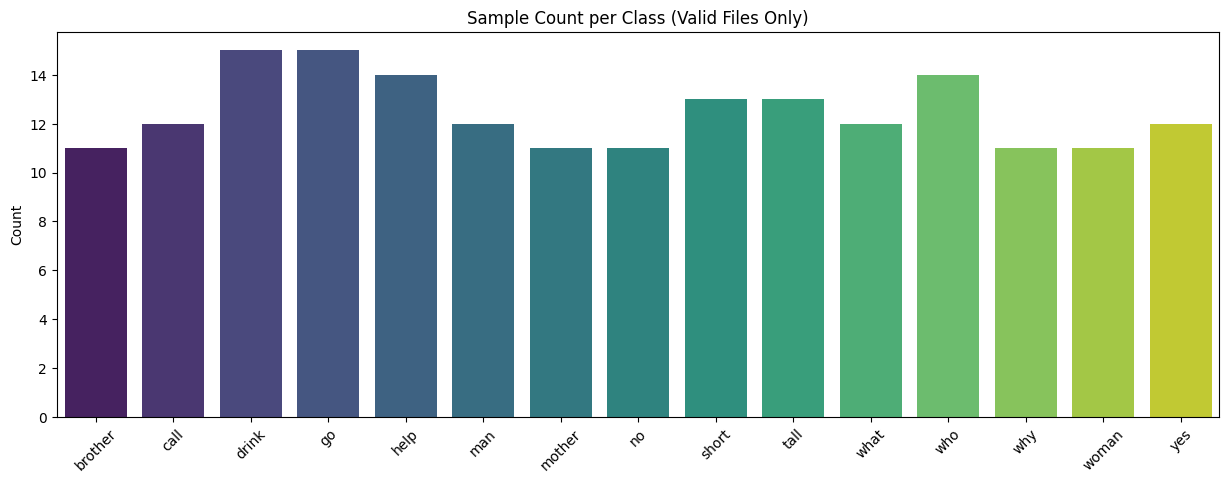


--- Visualizing Random Sample: 'why' ---
Source: /content/drive/MyDrive/ml-project/inputs/extracted_landmarks/why/why_63285.npy


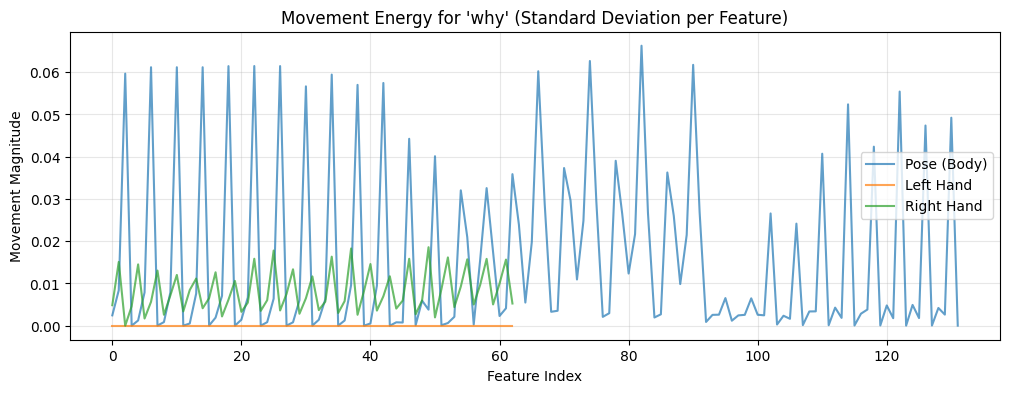

INTERPRETATION:
- Peaks in the graph indicate parts of the body moving.
- If 'Right Hand' is flatline (near 0), the person might be only using their Left Hand.
- If EVERYTHING is near 0, the video is static (bad sample).


In [ ]:
# 1. CONFIGURATION
# Based on your provided path
EXPECTED_SHAPE = (30, 258) # 30 frames, 258 features

# 2. DATA LOADING & AUDIT
print(f"--- Starting Data Audit in: {LANDMARKS_PATH} ---")

class_counts = defaultdict(int)
errors = []
shapes = []
valid_samples = [] # Store path and label for visualization later

# Get list of class folders
if not os.path.exists(LANDMARKS_PATH):
    print(f"ERROR: Path not found: {LANDMARKS_PATH}")
else:
    classes = [d for d in os.listdir(LANDMARKS_PATH) if os.path.isdir(os.path.join(LANDMARKS_PATH, d))]
    classes.sort()

    for label in classes:
        class_dir = os.path.join(LANDMARKS_PATH, label)
        files = [f for f in os.listdir(class_dir) if f.endswith('.npy')]

        for f in files:
            file_path = os.path.join(class_dir, f)
            try:
                # Load data
                data = np.load(file_path)

                # Check 1: Shape
                if data.shape != EXPECTED_SHAPE:
                    errors.append(f"SHAPE MISMATCH: {label}/{f} -> {data.shape}")
                    continue

                # Check 2: NaN or Inf values (Corrupted extraction)
                if np.isnan(data).any() or np.isinf(data).any():
                    errors.append(f"CORRUPTED VALUES (NaN/Inf): {label}/{f}")
                    continue

                # Check 3: Dead Frames (All zeros)
                # If a frame is entirely zeros, MediaPipe lost the person
                zero_frames = np.all(data == 0, axis=1)
                if np.any(zero_frames):
                    # It's okay to have *some* zero frames, but let's note it if it's the whole file
                    if np.all(zero_frames):
                        errors.append(f"EMPTY FILE (All Zeros): {label}/{f}")
                        continue

                # If passed, add to valid count
                class_counts[label] += 1
                shapes.append(data.shape)
                valid_samples.append({'path': file_path, 'label': label, 'data': data})

            except Exception as e:
                errors.append(f"LOAD ERROR: {label}/{f} -> {str(e)}")

# 3. REPORTING
print(f"\n--- Audit Complete ---")
print(f"Total Valid Samples: {len(valid_samples)}")
if errors:
    print(f"\n[!] Found {len(errors)} issues:")
    for e in errors[:5]: # Show first 5 errors
        print(f" - {e}")
    if len(errors) > 5: print(f" ... and {len(errors)-5} more.")
else:
    print("No data corruption found. All files are clean!")

# 4. VISUALIZATION: Class Distribution
plt.figure(figsize=(15, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), legend=False, palette='viridis')
plt.title("Sample Count per Class (Valid Files Only)")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

# 5. VISUALIZATION: Landmark "Sanity Check"
# We will plot the "activity" of a random file to see if it looks like a sign
if valid_samples:
    sample = random.choice(valid_samples)
    data = sample['data']
    label = sample['label']

    print(f"\n--- Visualizing Random Sample: '{label}' ---")
    print(f"Source: {sample['path']}")

    # Slice the data based on your 258 feature layout:
    # Pose (132) + Left Hand (63) + Right Hand (63)
    pose = data[:, :132]
    lh   = data[:, 132:195]
    rh   = data[:, 195:258]

    # Calculate movement (Standard Deviation across 30 frames)
    # High std dev = lots of movement. Low std dev = static.
    plt.figure(figsize=(12, 4))
    plt.plot(np.std(pose, axis=0), label='Pose (Body)', alpha=0.7)
    plt.plot(np.std(lh, axis=0), label='Left Hand', alpha=0.7)
    plt.plot(np.std(rh, axis=0), label='Right Hand', alpha=0.7)
    plt.title(f"Movement Energy for '{label}' (Standard Deviation per Feature)")
    plt.xlabel("Feature Index")
    plt.ylabel("Movement Magnitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("INTERPRETATION:")
    print("- Peaks in the graph indicate parts of the body moving.")
    print("- If 'Right Hand' is flatline (near 0), the person might be only using their Left Hand.")
    print("- If EVERYTHING is near 0, the video is static (bad sample).")

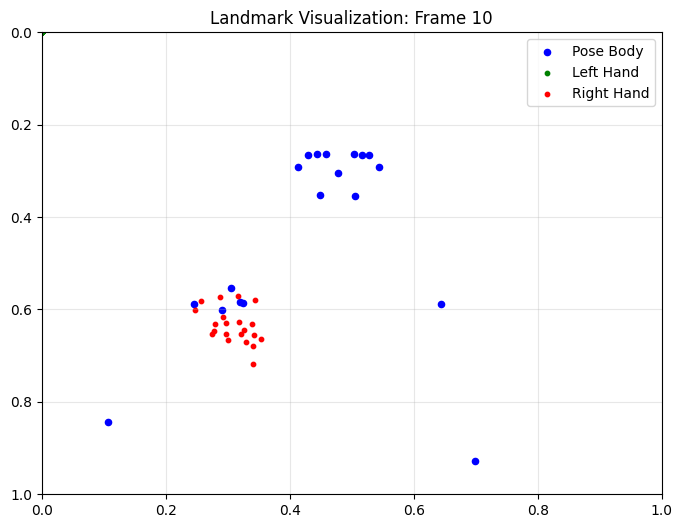

In [ ]:
# 1. Select a file to test
# Replace this with any path from your 'valid_samples' list or a specific file
test_file_path = f"{LANDMARKS_PATH}/yes/yes_64280.npy"

# 2. Load the data
data = np.load(test_file_path) # Shape (30, 258)
frame_index = 10 # Pick a frame in the middle of the action

# 3. Extract Coordinates for that frame
frame_data = data[frame_index]

# Feature Mapping (based on your 258 features)
# Pose: 33 landmarks * 4 (x, y, z, vis) = 132 indices
pose = frame_data[:132].reshape(33, 4)
pose_x = pose[:, 0]
pose_y = pose[:, 1]

# Left Hand: 21 landmarks * 3 (x, y, z) = 63 indices
# Starts after Pose (132)
lh = frame_data[132:195].reshape(21, 3)
lh_x = lh[:, 0]
lh_y = lh[:, 1]

# Right Hand: 21 landmarks * 3 (x, y, z) = 63 indices
# Starts after Left Hand (132 + 63 = 195)
rh = frame_data[195:258].reshape(21, 3)
rh_x = rh[:, 0]
rh_y = rh[:, 1]

# 4. Plotting
plt.figure(figsize=(8, 6))
plt.title(f"Landmark Visualization: Frame {frame_index}")

# Setup the "Screen" (Standard 0-1 coordinates)
plt.xlim(0, 1)
plt.ylim(1, 0) # INVERT Y-axis because images have (0,0) at top-left!

# Draw Points
plt.scatter(pose_x, pose_y, c='blue', label='Pose Body', s=20)
plt.scatter(lh_x, lh_y, c='green', label='Left Hand', s=10)
plt.scatter(rh_x, rh_y, c='red', label='Right Hand', s=10)

# Optional: Draw connections (Skeleton lines) could be added here,
# but scatter is enough to see if it looks human.

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

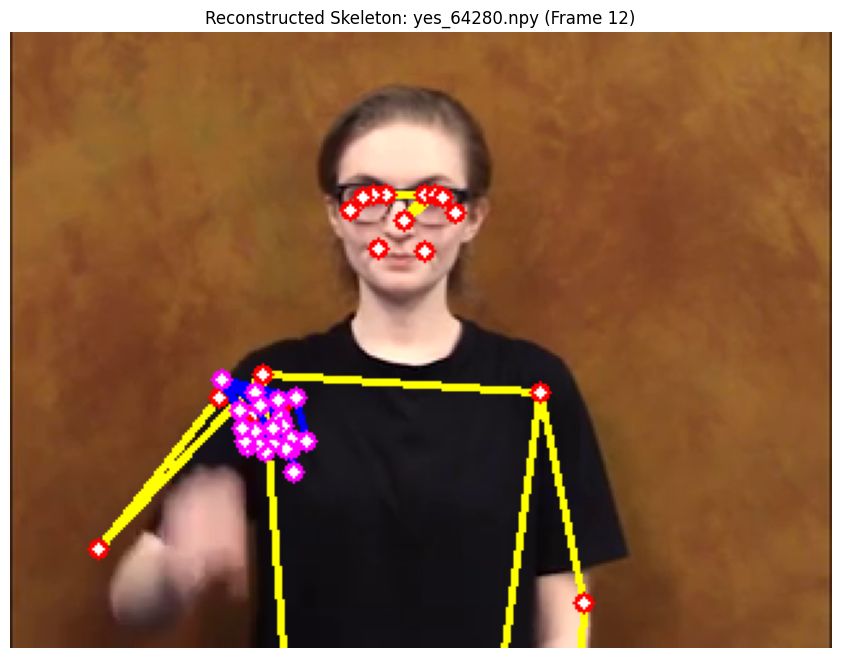

In [ ]:
# --- 1. CONFIGURATION ---
# Path to your .npy file
npy_path = f"{LANDMARKS_PATH}/yes/yes_64280.npy"
video_path = f"{RAW_DATASET_PATH}/yes/yes_64280.mp4"

# Extract just the file name from the full path to display in the plot title
filename = os.path.basename(npy_path)


# --- 2. DEFINE CONNECTIONS (The "Skeleton") ---
# These are the standard pairs of indices that MediaPipe connects
HAND_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,4),         # Thumb
    (0,5), (5,6), (6,7), (7,8),         # Index
    (0,9), (9,10), (10,11), (11,12),    # Middle
    (0,13), (13,14), (14,15), (15,16),  # Ring
    (0,17), (17,18), (18,19), (19,20)   # Pinky
]

# Simplified Pose connections for upper body
POSE_CONNECTIONS = [
    (11, 12), (11, 13), (13, 15),       # Left Arm
    (12, 14), (14, 16),                 # Right Arm
    (11, 23), (12, 24), (23, 24),       # Torso
    (23, 25), (24, 26),                 # Hips to Knees (if visible)
    (0, 1), (1, 4), (0, 2), (2, 5)      # Face (simplified)
]

# --- 3. DRAWING FUNCTION ---
def draw_landmarks(image, landmarks):
    h, w, _ = image.shape

    # --- SPLIT DATA ---
    # Pose: 0-132 (33 points * 4) -> We only need x,y
    pose_flat = landmarks[:132]
    pose = pose_flat.reshape(33, 4)[:, :2]

    # Left Hand: 132-195 (21 points * 3)
    lh_flat = landmarks[132:195]
    lh = lh_flat.reshape(21, 3)[:, :2]

    # Right Hand: 195-258 (21 points * 3)
    rh_flat = landmarks[195:258]
    rh = rh_flat.reshape(21, 3)[:, :2]

    # --- HELPER TO DRAW LINES & DOTS ---
    def draw_skeleton(points, connections, color_line, color_dot):
        # 1. Draw Lines (Skeleton)
        for i, j in connections:
            if i >= len(points) or j >= len(points): continue

            x1, y1 = points[i]
            x2, y2 = points[j]

            # Skip if point is 0,0 (undetected)
            if (x1==0 and y1==0) or (x2==0 and y2==0): continue

            p1 = (int(x1 * w), int(y1 * h))
            p2 = (int(x2 * w), int(y2 * h))
            cv2.line(image, p1, p2, color_line, 2)

        # 2. Draw Dots (Joints)
        for x, y in points:
            if x==0 and y==0: continue
            px, py = int(x * w), int(y * h)
            cv2.circle(image, (px, py), 4, color_dot, -1)
            cv2.circle(image, (px, py), 2, (255, 255, 255), -1) # White center for style

    # Draw Pose (Cyan lines, Blue dots)
    draw_skeleton(pose, POSE_CONNECTIONS, (255, 255, 0), (255, 0, 0))

    # Draw Left Hand (Green lines, Orange dots)
    draw_skeleton(lh, HAND_CONNECTIONS, (0, 255, 0), (0, 165, 255))

    # Draw Right Hand (Red lines, Pink dots)
    draw_skeleton(rh, HAND_CONNECTIONS, (0, 0, 255), (255, 0, 255))

# --- 4. EXECUTION ---
# Capture Video
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = 12  # Pick a frame with action

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame = cap.read()
cap.release()

if ret:
    # Load Data
    data = np.load(npy_path)

    # Handle index bounds
    current_lm = data[frame_idx] if frame_idx < len(data) else data[-1]

    # Draw!
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    draw_landmarks(frame_rgb, current_lm)

    # Show
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Reconstructed Skeleton: {filename} (Frame {frame_idx})")
    plt.show()
else:
    print("Could not read video frame.")

## Data Augmentation for Landmarks

To improve model generalization and simulate real-world variations, we apply **augmentation** directly on the extracted landmark sequences. Unlike image augmentation, we modify the numerical coordinates of pose and hand landmarks.

### Why Augmentation?
- Our dataset has limited samples per sign.
- Augmentation introduces **small variations** in position, scale, and noise.
- Helps prevent **overfitting** and improves model robustness.

### How We Augment Landmarks
1. **Jitter/Noise**: Add small random Gaussian noise to (x, y, z) coordinates.
2. **Scaling**: Simulate slight changes in camera distance by scaling the landmarks.
3. **Translation (optional)**: Slight shifts along x and y axes.
4. **Time Warping (optional)**: Slightly stretch or compress the sequence across frames.

### Implementation Example
We create multiple augmented versions of each video by applying noise and scaling:



## Saving Landmark Data after augmentation

To improve model generalization, we apply **augmentation** directly on the extracted landmark sequences. For each original video, we create multiple augmented versions by adding **small noise** and **scaling**.  
We then save all augmented `.npy` files in a folder organized by class and compress it into a ZIP file so it can be downloaded safely.

`If you run this code, the file will be automatically downloaded.`

- **Why**: Augmentation helps prevent overfitting and simulates real-world variations.
- **How**: Jitter/noise + scaling of landmarks.
- **Output**: ZIP file containing all augmented data ready for training.


In [ ]:
# The following code augments the extracted landmarks IF NOT present already

# --- CONFIGS ---
NUM_AUG = 5  # Number of augmented versions per video

def augment_landmarks(sequence, amount=0.05):
    sequence = np.array(sequence)
    noise = np.random.normal(0, amount, sequence.shape)
    augmented = sequence + noise
    scale_factor = np.random.uniform(0.9, 1.1)
    augmented = augmented * scale_factor
    return augmented

# --- GET LIST OF VALID FILES ---
valid_samples = []
classes = [d for d in os.listdir(LANDMARKS_PATH)
           if os.path.isdir(os.path.join(LANDMARKS_PATH, d))]
classes.sort()

for label in classes:
    class_dir = os.path.join(LANDMARKS_PATH, label)
    files_list = [f for f in os.listdir(class_dir) if f.endswith('.npy')]
    for f in files_list:
        valid_samples.append({'path': os.path.join(class_dir, f), 'label': label})

os.makedirs(AUG_LANDMARKS_PATH, exist_ok=True)

# --- AUGMENT ONLY IF MISSING ---
skipped = 0
created = 0

for sample in valid_samples:
    file_path = sample['path']
    label = sample['label']

    class_folder = os.path.join(AUG_LANDMARKS_PATH, label)
    os.makedirs(class_folder, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # Check if ALL augmented versions already exist
    expected_files = [
        os.path.join(class_folder, f"{base_name}_aug{i+1}.npy")
        for i in range(NUM_AUG)
    ]

    if all(os.path.exists(p) for p in expected_files):
        skipped += 1
        continue  # Skip this file completely

    # Otherwise generate missing ones only
    data = np.load(file_path)

    for i, save_path in enumerate(expected_files):
        if not os.path.exists(save_path):
            aug_data = augment_landmarks(data)
            np.save(save_path, aug_data)
            created += 1

print(f"New augmented files created: {created}")
print(f"Original samples skipped (already complete): {skipped}")
print(f"Augmented dataset location: {AUG_LANDMARKS_PATH}")

New augmented files created: 0
Original samples skipped (already complete): 187
Augmented dataset location: /content/drive/MyDrive/ml-project/inputs/augmented_landmarks


In [ ]:
# get summary

def get_augmented_summary(path):
    if not os.path.exists(path):
        print(f"Error: The path '{path}' does not exist.")
        print("Double-check your Drive mount and folder path.")
        return

    print(f"{'Word (Class)':<15} | {'Augmented .npy':<15} | {'Base Samples':<13}")
    print("-" * 50)

    classes = [d for d in os.listdir(path)
               if os.path.isdir(os.path.join(path, d)) and not d.startswith('.')]
    classes.sort()

    total_aug = 0
    total_base = 0

    for word in classes:
        word_dir = os.path.join(path, word)

        npy_files = [f for f in os.listdir(word_dir) if f.lower().endswith('.npy')]
        aug_count = len(npy_files)

        # Extract base sample IDs (before _aug)
        base_ids = set()
        for f in npy_files:
            base_name = f.split('_aug')[0]  # e.g. brother_07932
            base_ids.add(base_name)

        base_count = len(base_ids)

        print(f"{word:<15} | {aug_count:<15} | {base_count:<13}")

        total_aug += aug_count
        total_base += base_count

    print("-" * 50)
    print(f"{'TOTAL':<15} | {total_aug:<15} | {total_base:<13}")


# Run it
get_augmented_summary(AUG_LANDMARKS_PATH)


Word (Class)    | Augmented .npy  | Base Samples 
--------------------------------------------------
brother         | 55              | 11           
call            | 60              | 12           
drink           | 75              | 15           
go              | 75              | 15           
help            | 70              | 14           
man             | 60              | 12           
mother          | 55              | 11           
no              | 55              | 11           
short           | 65              | 13           
tall            | 65              | 13           
what            | 60              | 12           
who             | 70              | 14           
why             | 55              | 11           
woman           | 55              | 11           
yes             | 60              | 12           
--------------------------------------------------
TOTAL           | 935             | 187          
